In [ ]:
#Extract all the training data and test data
!cp '/content/drive/My Drive/Projects/Nishikita Competition/data.zip' /content/
!unzip /content/data.zip
!unzip /content/train.zip
!unzip /content/test.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/n_01180.jpg       
  inflating: train/n_03420.jpg       
  inflating: train/n_00970.jpg       
  inflating: train/n_03709.jpg       
  inflating: train/n_01967.jpg       
  inflating: train/n_03507.jpg       
  inflating: train/n_00854.jpg       
  inflating: train/n_04549.jpg       
  inflating: train/n_00470.jpg       
  inflating: train/n_02222.jpg       
  inflating: train/n_00305.jpg       
  inflating: train/n_03576.jpg       
  inflating: train/n_00526.jpg       
  inflating: train/n_00708.jpg       
  inflating: train/n_03032.jpg       
  inflating: train/n_04688.jpg       
  inflating: train/n_00516.jpg       
  inflating: train/n_03807.jpg       
  inflating: train/n_02134.jpg       
  inflating: train/n_02929.jpg       
  inflating: train/n_04367.jpg       
  inflating: train/n_05162.jpg       
  inflating: train/n_00272.jpg       
  inflating: train/n_05097.jpg       
  inflating: train/n_01494.jpg       

In [ ]:
!pip install -U --pre efficientnet
!pip install tf2cv

     |████████████████████████████████| 348kB 13.7MB/s 


In [ ]:
import numpy as np 
import tensorflow 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D,Dense,concatenate,Input
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet101,ResNet50,ResNet152
from tensorflow.keras.utils import Sequence 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import *
from tensorflow import keras
import efficientnet.tfkeras as efn
import math
import tf2cv
from tf2cv.model_provider import get_model as tf2cv_get_model
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate,Cutout
)
#@title Imports
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import time
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from tf2cv.model_provider import _models as models
import re

In [ ]:
data_dir='/content/'
classes_map={
    0: 'Male-Aristocrat', 1: 'Male-Samurai', 2: 'Male-Animal', 3: 'Male-Common People',
4: 'Female-Aristocrat', 5: 'Female-Samurai', 6: 'Female-Animal' , 7: 'Woman-common people'
}

img_size=256
batch_size=128
epochs=10
n_classes=len(classes_map.items())
lr=1e-5
max_lr=1e-4
model_dir='/content/drive/My Drive/Projects/Nishikita Competition/Models/'
SIZE=img_size

In [ ]:
models=[i for i in models if re.search(r'senet',i)]

In [ ]:
train_df=pd.read_csv(data_dir+'train.csv')
train_df['image']=train_df['image'].apply(lambda x:data_dir+'train/'+x)
train_df.head()

,image,gender_status
0,/content/train/n_00001.jpg,4
1,/content/train/n_00002.jpg,0
2,/content/train/n_00003.jpg,0
3,/content/train/n_00005.jpg,0
4,/content/train/n_00006.jpg,0


In [ ]:
sample_submission=pd.read_csv(data_dir+'sample_submission.csv')
sample_submission.head()

,image,gender_status
0,n_00000.jpg,0
1,n_00004.jpg,0
2,n_00009.jpg,0
3,n_00026.jpg,0
4,n_00030.jpg,0


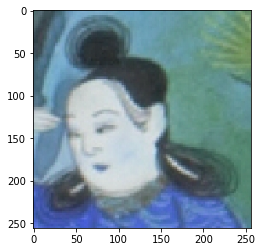

In [ ]:
import cv2
img_sample=cv2.imread(train_df.iloc[0].image)
plt.imshow(img_sample)

In [ ]:
# augmix : https://github.com/google-research/augmix

from PIL import Image
from PIL import ImageOps
import numpy as np

def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled to
      level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.

def sample_level(n):
    return np.random.uniform(low=0.1, high=n)

def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)

def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)

def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)

def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)

def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)

def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((SIZE, SIZE),
                           Image.AFFINE, (1, level, 0, 0, 1, 0),
                           resample=Image.BILINEAR)

def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((SIZE, SIZE),
                           Image.AFFINE, (1, 0, 0, level, 1, 0),
                           resample=Image.BILINEAR)

def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), SIZE / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((SIZE, SIZE),
                           Image.AFFINE, (1, 0, level, 0, 1, 0),
                           resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), SIZE / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((SIZE, SIZE),
                           Image.AFFINE, (1, 0, 0, 0, 1, level),
                           resample=Image.BILINEAR)

augmentations = [
    autocontrast, equalize, posterize, rotate, solarize, shear_x, shear_y,
    translate_x, translate_y
]



def apply_op(image, op, severity):
    image = np.clip(image * 255., 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img) / 255.


def augment_and_mix(image, severity=1, width=3, depth=1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
    image: Raw input image as float32 np.ndarray of shape (h, w, c)
    severity: Severity of underlying augmentation operators (between 1 to 10).
    width: Width of augmentation chain
    depth: Depth of augmentation chain. -1 enables stochastic depth uniformly
      from [1, 3]
    alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
    mixed: Augmented and mixed image.
  """
    ws = np.float32(
      np.random.dirichlet([alpha] * width))
    m = np.float32(np.random.beta(alpha, alpha))

    mix = np.zeros_like(image)
    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
        mix = np.add(mix, ws[i] * (image_aug), out=mix, 
                     casting="unsafe")

    mixed = (1 - m) * (image) + m * mix
    return mixed

In [ ]:
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    #RandomContrast(limit=0.2, p=0.5),
    #RandomGamma(gamma_limit=(80, 120), p=0.5),
    #RandomBrightness(limit=0.2, p=0.5),
    #HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       #val_shift_limit=10, p=.9),
    # CLAHE(p=1.0, clip_limit=2.0),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8),
    Cutout(), 
    ToFloat(max_value=255)
])

AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

import numpy as np


class AnimeData(Sequence):
  def __init__(self,x_set,y_set,batch_size=128,augmentations=AUGMENTATIONS_TEST,train=False):
    self.x=x_set
    self.y=y_set
    self.batch_size=batch_size 
    self.augmentations=augmentations
    self.train=train
  def __getitem__(self,step):
    start=step*self.batch_size 
    end=(step+1)*self.batch_size 
    x_batch,y_batch=self.x[start:end],self.y[start:end]
    x_batch,y_batch=self.data_gen(x_batch,y_batch)
    if self.train:
      l2=np.random.randint(0,self.y.shape[0],x_batch.shape[0])
      x2,y2=self.x[l2],self.y[l2]
      x2,y2=self.data_gen(x2,y2)
      alphas=np.random.beta(0.4,0.4,x_batch.shape[0])
      l1=np.resize(alphas,(x_batch.shape[0],1,1,1))
      ly=np.resize(alphas,(x_batch.shape[0],1))
      x_batch=l1*x_batch+(1-l1)*x2
      y_batch=ly*y_batch+(1-ly)*y2
    return x_batch,y_batch
  
  def data_gen(self,batch_x,batch_y):
    x_batch=np.empty((batch_y.shape[0],img_size,img_size,3))
    y_batch=np.empty((batch_y.shape[0],n_classes))
    for i in range(batch_y.shape[0]):
      x=cv2.imread(batch_x[i])
      x=self.augmentations(image=x)["image"]
      y=batch_y[i]
      x_batch[i]=x
      y_batch[i]=y
    return np.array(x_batch),np.array(y_batch)
  
  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)

In [ ]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
def get_efficientnet(shape=(img_size,img_size,3),weights='noisy-student',trainable_base=False,name='b7'):
  if name=='b7':
    base=efn.EfficientNetB7(weights=weights,input_shape=shape,include_top=False)
  elif name=='b6':
    base=efn.EfficientNetB6(weights=weights,input_shape=shape,include_top=False)
  elif name=='b5':
    base=efn.EfficientNetB5(weights=weights,input_shape=shape,include_top=False)
  elif name=='b4':
    base=efn.EfficientNetB4(weights=weights,input_shape=shape,include_top=False)
  elif name=='b3':
    base=efn.EfficientNetB3(weights=weights,input_shape=shape,include_top=False)
  elif name=='b2':
    base=efn.EfficientNetB2(weights=weights,input_shape=shape,include_top=False)
  elif name=='b1':
    base=efn.EfficientNetB1(weights=weights,input_shape=shape,include_top=False)
  elif name=='l2':
    base=efn.EfficientNetL2(weights=weights,input_shape=shape,include_top=False)
  base.trainable=trainable_base
  avg_pool=GlobalAveragePooling2D()(base.output)
  #max_pool=GlobalMaxPooling2D()(base.output)
  #out=concatenate([avg_pool,max_pool])
  #avg_pool=Dense(1024,activation='relu')(avg_pool)
  out=Dense(n_classes,activation='softmax')(avg_pool)
  model=Model(inputs=[base.input],outputs=[out])
  return model



def get_tf2cv_model(input_shape=(img_size,img_size,3),trainable_base=False):
  net=tf2cv_get_model('senet154',pretrained=True)
  net.trainable=trainable_base
  inp=Input(input_shape)
  model_out=net.layers[-2](inp)
  model_out=GlobalAveragePooling2D()(model_out)
  model_out=Dense(n_classes,activation='softmax')(model_out)
  model=Model(inputs=[inp],outputs=[model_out])
  return model


def get_bitresnet(input_shape=(img_size,img_size,3),trainable_base=False):
  # Load model into KerasLayer
  inp=Input(shape=input_shape)
  #model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
  model_url="https://tfhub.dev/google/bit/m-r101x1/1"
  module = hub.KerasLayer(model_url)
  model_out=module(inp)
  model_out=Dense(n_classes,activation='softmax')(model_out)
  model=Model(inputs=[inp],outputs=[model_out])
  return model



In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
train_y=lb.fit_transform(train_df.gender_status.values)

In [ ]:
from sklearn.model_selection import KFold 
folds=KFold(n_splits=5,shuffle=True)
splits=folds.split(train_df.image.values,y=train_df.gender_status.values)

In [ ]:
model_name='bitresnet'
variant='101'

In [ ]:
for i,(train_idx,val_idx) in enumerate(splits):
  print(f'Fold {i+1}')
  path=model_dir+model_name+variant+'_fold_'+str(i+1)+'.hdf5'
  best_path=model_dir+model_name+variant+'_fold_best'+str(i+1)+'.hdf5'
  #model=get_efficientnet(name='b6',weights='imagenet')
  model=get_bitresnet()
  #model.load_weights(path)
  train_gen=AnimeData(train_df.image.values[train_idx],train_y[train_idx],8,augmentations=AUGMENTATIONS_TRAIN,train=True)
  val_gen=AnimeData(train_df.image.values[val_idx],train_y[val_idx],8,augmentations=AUGMENTATIONS_TEST,train=False)
  model.trainable=True
  model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=1e-6),metrics=['accuracy',f1_m])
  cycle=CyclicLR(mode='exp_range',base_lr=lr,max_lr=max_lr,step_size=4*len(train_gen))
  checkpoint=ModelCheckpoint(path,save_best_only=False,save_weights_only=True)
  best_checkpoint=ModelCheckpoint(best_path,save_best_only=True,save_weights_only=True)
  model.fit(train_gen,epochs=9,validation_data=val_gen,validation_steps=len(val_gen),callbacks=[cycle,checkpoint,best_checkpoint])
  """for _ in range(2):
    lr/=10
    max_lr/=10
    cycle=CyclicLR(mode='exp_range',base_lr=lr,max_lr=max_lr,step_size=4*len(train_gen))
    model.fit(train_gen,epochs=3,validation_data=val_gen,validation_steps=len(val_gen),callbacks=[cycle,checkpoint,best_checkpoint])"""



Fold 1
Epoch 1/9
424/424 [==============================] - 168s 397ms/step - loss: 1.4477 - accuracy: 0.5923 - f1_m: 0.5234 - val_loss: 0.9722 - val_accuracy: 0.7052 - val_f1_m: 0.7031
Epoch 2/9
424/424 [==============================] - 167s 394ms/step - loss: 0.9529 - accuracy: 0.7413 - f1_m: 0.6564 - val_loss: 0.6803 - val_accuracy: 0.7535 - val_f1_m: 0.7538
Epoch 3/9
424/424 [==============================] - 167s 394ms/step - loss: 0.8426 - accuracy: 0.7932 - f1_m: 0.6913 - val_loss: 0.6394 - val_accuracy: 0.7771 - val_f1_m: 0.7763
Epoch 4/9
424/424 [==============================] - 167s 394ms/step - loss: 0.8199 - accuracy: 0.7991 - f1_m: 0.7034 - val_loss: 0.6245 - val_accuracy: 0.7736 - val_f1_m: 0.7744
Epoch 5/9
424/424 [==============================] - 167s 395ms/step - loss: 0.7440 - accuracy: 0.8336 - f1_m: 0.7417 - val_loss: 0.5340 - val_accuracy: 0.8090 - val_f1_m: 0.8062
Epoch 6/9
424/424 [==============================] - 165s 390ms/step - loss: 0.6722 - accuracy: 0.

In [ ]:
#Training on Full Data
epochs=12
path=model_dir+model_name+variant+'.hdf5'
train_gen=AnimeData(train_df.image.values,train_y,8,augmentations=AUGMENTATIONS_TRAIN,train=True)
model=get_bitresnet()
model.trainable=True
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=1e-5),metrics=['accuracy',f1_m])
checkpoint=ModelCheckpoint(path,save_best_only=False,save_weights_only=True)
cycle=CyclicLR(mode='exp_range',base_lr=lr,max_lr=max_lr)
model.fit(train_gen,epochs=epochs,callbacks=[checkpoint,cycle])

for _ in range(2):
  lr,max_lr=lr/10,max_lr/10
  epochs-=4
  checkpoint=ModelCheckpoint(path,save_best_only=False,save_weights_only=True)
  cycle=CyclicLR(mode='exp_range',base_lr=lr,max_lr=max_lr)
  model.fit(train_gen,epochs=8,callbacks=[checkpoint,cycle])

Epoch 1/12
530/530 [==============================] - 135s 255ms/step - loss: 1.3481 - accuracy: 0.6008 - f1_m: 0.5050
Epoch 2/12
530/530 [==============================] - 136s 256ms/step - loss: 0.9232 - accuracy: 0.7478 - f1_m: 0.6482
Epoch 3/12
530/530 [==============================] - 136s 256ms/step - loss: 0.8230 - accuracy: 0.7902 - f1_m: 0.6969
Epoch 4/12
530/530 [==============================] - 135s 255ms/step - loss: 0.7725 - accuracy: 0.8152 - f1_m: 0.7165
Epoch 5/12
530/530 [==============================] - 136s 256ms/step - loss: 0.7118 - accuracy: 0.8358 - f1_m: 0.7491
Epoch 6/12
530/530 [==============================] - 136s 256ms/step - loss: 0.6595 - accuracy: 0.8695 - f1_m: 0.7726
Epoch 7/12
530/530 [==============================] - 135s 256ms/step - loss: 0.6345 - accuracy: 0.8841 - f1_m: 0.7873
Epoch 8/12
530/530 [==============================] - 135s 256ms/step - loss: 0.6121 - accuracy: 0.8879 - f1_m: 0.7946
Epoch 9/12
530/530 [============================

KeyboardInterrupt: ignored